In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from pytz import timezone

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical
from keras import optimizers
import keras
import talib

import time

import pywt
from statsmodels.robust import stand_mad
import os

fig_size = (12, 9)
plt.rcParams["figure.figsize"] = fig_size


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

Using TensorFlow backend.


In [18]:
epochs  = 10
seq_len = 50

print('> Loading data... ')

X_train, y_train, X_test, y_test = load_data('sp500.csv', seq_len, True)

> Loading data... 


In [20]:
print('> Data Loaded. Compiling...')
model = build_model([1, 50, 100, 1])

model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=epochs,
    validation_split=0.05)

predicted = predict_point_by_point(model, X_test)

> Data Loaded. Compiling...
> Compilation Time :  0.020959138870239258
Train on 3523 samples, validate on 186 samples
Epoch 1/10
3523/3523 [==============================] - 6s - loss: 0.0026 - val_loss: 0.0011
Epoch 2/10
3523/3523 [==============================] - 5s - loss: 7.5676e-04 - val_loss: 6.2345e-04
Epoch 3/10
3523/3523 [==============================] - 5s - loss: 5.9249e-04 - val_loss: 5.9777e-04
Epoch 4/10
3523/3523 [==============================] - 5s - loss: 6.8442e-04 - val_loss: 5.1605e-04
Epoch 5/10
3523/3523 [==============================] - 5s - loss: 5.2728e-04 - val_loss: 7.9099e-04
Epoch 6/10
3523/3523 [==============================] - 5s - loss: 5.8537e-04 - val_loss: 5.6086e-04
Epoch 7/10
3523/3523 [==============================] - 5s - loss: 5.5911e-04 - val_loss: 5.0751e-04
Epoch 8/10
3523/3523 [==============================] - 5s - loss: 4.4679e-04 - val_loss: 4.4561e-04
Epoch 9/10
3523/3523 [==============================] - 5s - loss: 5.0007e-04 - va

In [29]:
np.corrcoef(y_test, predicted)

array([[ 1.        ,  0.95676055],
       [ 0.95676055,  1.        ]])

In [32]:
np.corrcoef(y_test, np.roll(y_test, 1))

array([[ 1.        ,  0.96254058],
       [ 0.96254058,  1.        ]])

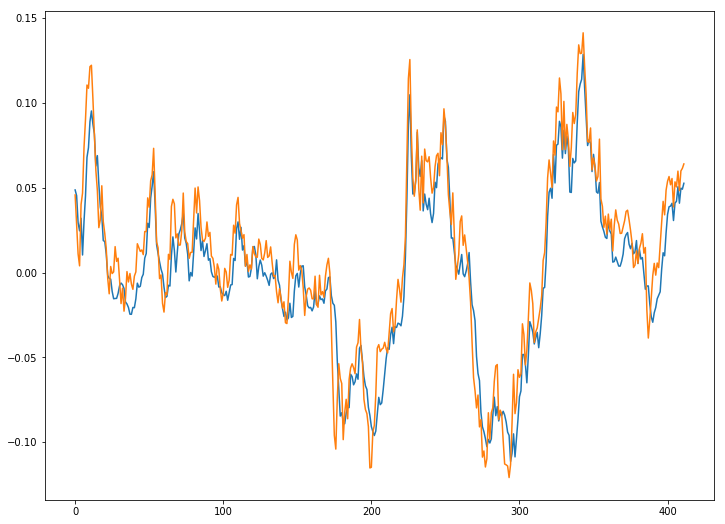

In [21]:
plt.clf()
plt.plot(predicted)
plt.plot(y_test)
plt.show()

## initial data without normalization

In [7]:
X_train, y_train, X_test, y_test = load_data('sp500.csv', seq_len, False)

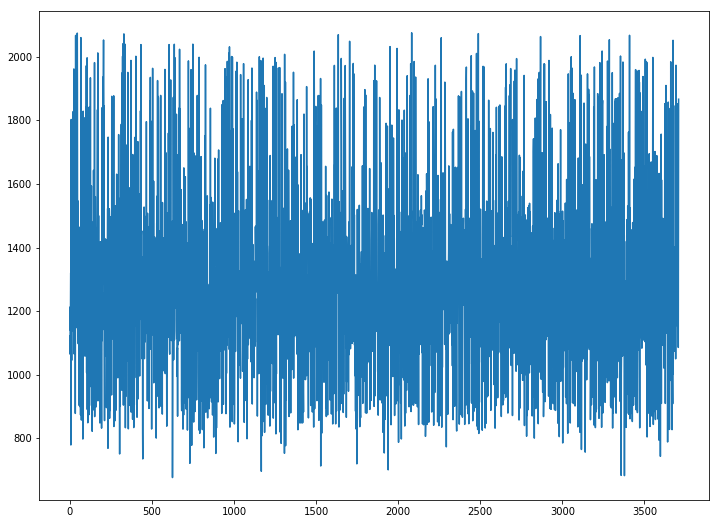

In [10]:
plt.clf()
plt.plot(y_train)
plt.show()

In [15]:
SP500 = pd.read_csv("sp500.csv", header=None, names=["AdjustedClose"])

In [16]:
SP500.plot()

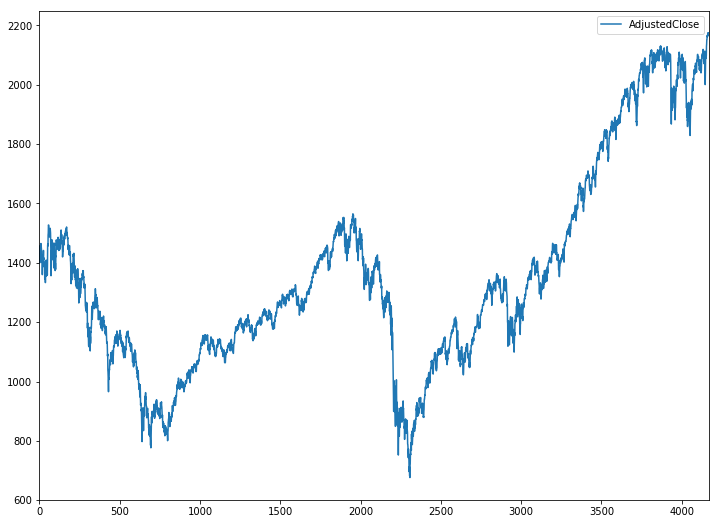

In [17]:
plt.show()